This brief example shows how to use the isochrones package to extract an isochrone for a specific location and time. 

It assumes that 
* the isochrones package has been properly installed and additional dependencies (matplotlib, numpy) have been installed (e.g. with `pip install isochrones[example]`)
* OpenTripPlanner (OTP) is running locally on the 8080 port
* the OTP data is stored in the `otp/graphs/main` subfolder

In [1]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import datetime
import contextily as ctx
from dotenv import load_dotenv

from isochrones import (
    calculate_isochrones,
    intersect_isochrones,
    get_osm_features,
    get_available_modes,
)

load_dotenv()
api_key = os.getenv("API_KEY")

In [2]:
# Define parameters
lat = 46.207690  # Charmilles, Geneva
lon = 6.127236

cutoffSec = [300, 600, 900]  # 2.5, 5, 10 minutes
# equivalent in minutes, for labeling purposes
cutoffLabels = [f"{sec // 60} min" for sec in cutoffSec]
date_time = datetime.datetime(2025, 5, 20, 16, 0)
otp_url = "https://lasur-otp.epfl.ch"

mode = "BICYCLE"
bike_speed = 18

# POI parameters
bounding_box = (
    lon - 0.3,
    lat - 0.3,
    lon + 0.3,
    lat + 0.3,
)

# bounding_box = (
#     5.882835,
#     46.068877,
#     6.337395,
#     46.325682,
# )  # from bbxofinder.com, Collonges - Fillinges, Cessy - La roche sur Foron

tags = {
    "amenity": True,
    "healthcare": True,
    "office": True,
    "public_Transport": True,
    "shop": True,
    "tourism": True,
}

# Isochrone styling
isochrone_colors = {
    cutoffSec[0]: {"color": "#440154", "label": cutoffLabels[0]},
    cutoffSec[1]: {"color": "#21918c", "label": cutoffLabels[1]},
    cutoffSec[2]: {"color": "#fde725", "label": cutoffLabels[2]},
}

# Additional POI styling
poi_categories = {
    "amenity": {"color": "red", "label": "Amenities"},
    "healthcare": {"color": "blue", "label": "Healthcare"},
    "office": {"color": "green", "label": "Offices"},
    "public_Transport": {"color": "purple", "label": "Public Transport"},
    "shop": {"color": "orange", "label": "Shops"},
    "tourism": {"color": "brown", "label": "Tourism"},
}

In [3]:
get_available_modes(otp_url, "default", api_key).keys()

dict_keys(['TRANSIT', 'RAIL', 'BUS', 'TRAM', 'FUNICULAR', 'CABLE_CAR', 'WALK', 'BICYCLE', 'CAR', 'TRANSIT_BICYCLE', 'PARKRIDE', 'KISSRIDE'])

In [4]:
output = calculate_isochrones(
    lat,
    lon,
    cutoffSec,
    date_time,
    mode,
    otp_url,
    api_key=api_key,
    bike_speed=bike_speed,
)

In [5]:
output

geometry  time
0  MULTIPOLYGON (((6.0891 46.2101, 6.0908 46.2106...   900
1  MULTIPOLYGON (((6.1064 46.2113, 6.1064 46.2113...   600
2  MULTIPOLYGON (((6.1204 46.2077, 6.1205 46.2066...   300

In [5]:
output.total_bounds

array([ 6.0891, 46.1873,  6.1619, 46.2304])

In [6]:
def plot_with_basemap(gdf, pois=None, figsize=(15, 15), zoom=12, crs="EPSG:3857"):
    # Convert to Web Mercator for contextily
    gdf_web = gdf.to_crs(crs)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Store handles for legends
    iso_handles = []
    poi_handles = []

    # Plot isochrones with categorical colors
    for time, style in isochrone_colors.items():
        mask = gdf_web["time"] == time
        if mask.any():
            gdf_web[mask].plot(ax=ax, color=style["color"], alpha=0.5)
            iso_handles.append(
                plt.Rectangle(
                    (0, 0), 1, 1, fc=style["color"], alpha=0.5, label=style["label"]
                )
            )

    # Plot POIs with categorical colors
    if pois is not None:
        pois_web = pois.to_crs(crs)
        for category, style in poi_categories.items():
            cat_pois = pois_web[pois_web["variable"] == category]
            if not cat_pois.empty:
                cat_pois.plot(
                    ax=ax, color=style["color"], marker="o", markersize=5, alpha=0.7
                )
                poi_handles.append(
                    plt.Line2D(
                        [0],
                        [0],
                        marker="o",
                        color=style["color"],
                        markersize=8,
                        linestyle="",
                        label=style["label"],
                    )
                )

    # Add basemap
    ctx.add_basemap(
        ax,
        crs=gdf_web.crs.to_string(),
        source=ctx.providers.SwissFederalGeoportal.NationalMapColor,
        zoom=zoom,
    )

    # Set bounds and remove axes
    minx, miny, maxx, maxy = gdf_web.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_axis_off()

    # Add dual legends
    if iso_handles:
        first_legend = ax.legend(
            handles=iso_handles,
            title="Travel Time",
            loc="upper left",
            frameon=True,
            framealpha=0.8,
        )
        ax.add_artist(first_legend)

    if poi_handles:
        ax.legend(
            handles=poi_handles,
            title="Points of Interest",
            loc="upper right",
            frameon=True,
            framealpha=0.8,
        )

    return fig, ax

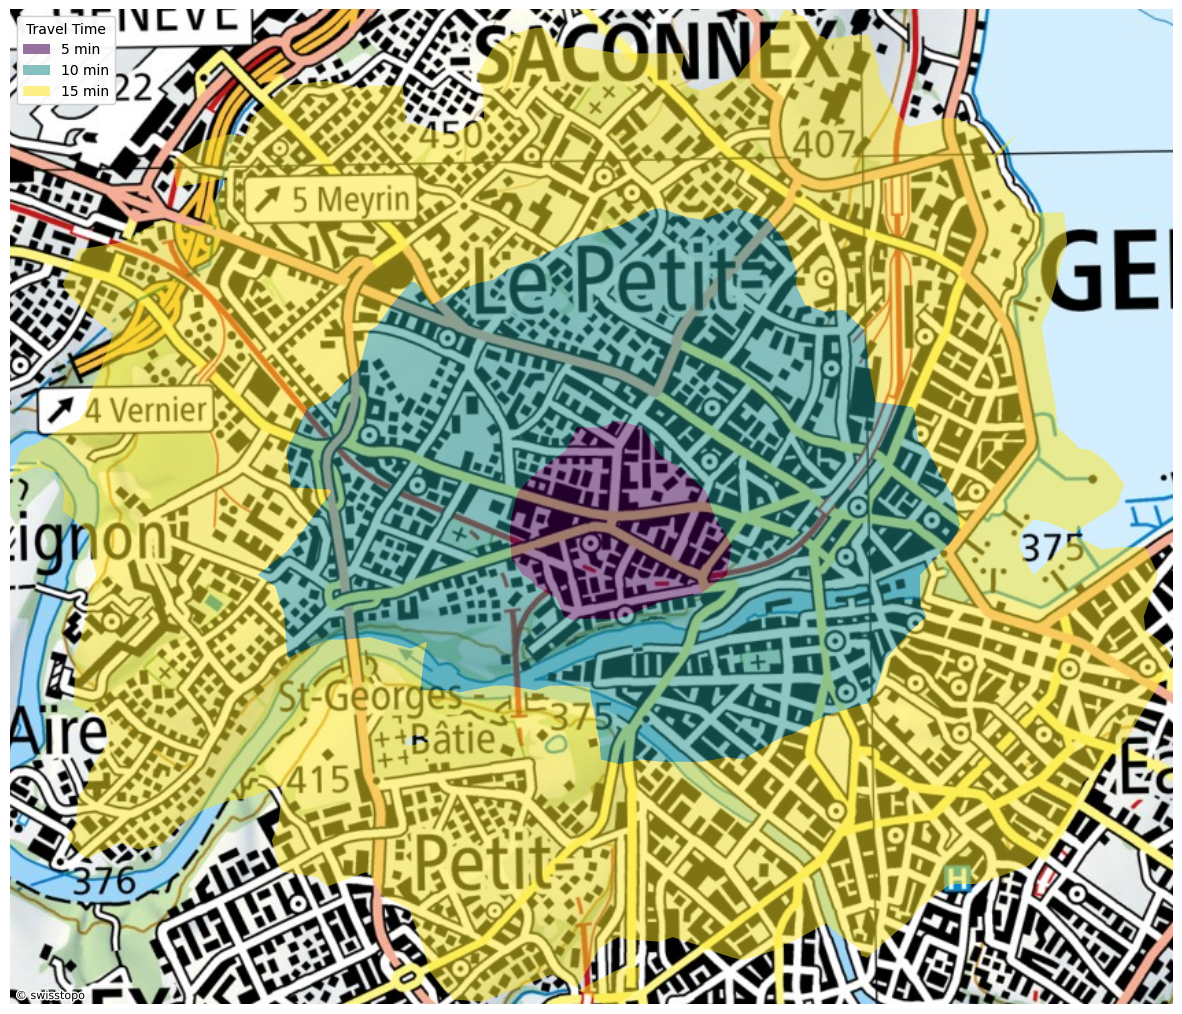

In [7]:
# Create plot with base layer
fig, ax = plot_with_basemap(output, zoom=14)
plt.show()

In [8]:
pois = get_osm_features(bounding_box, tags)

In [9]:
intersected_pois = intersect_isochrones(output, pois.to_crs("EPSG:4326"))

In [10]:
intersected_pois = intersected_pois[intersected_pois["time"] == cutoffSec[-1]]

In [11]:
intersected_pois

osm_type      osm_id variable             value  time  \
0         node    25701890  amenity  place_of_worship   900   
3         node    34227829  amenity        university   900   
5         node    36172036  amenity          townhall   900   
6         node    36174874  amenity      fire_station   900   
8         node    36249470  amenity  place_of_worship   900   
...        ...         ...      ...               ...   ...   
14442      way   666867586  tourism           artwork   900   
14443      way   666867587  tourism           artwork   900   
14444      way   865425438  tourism           artwork   900   
14445      way   960789353  tourism           artwork   900   
14447      way  1199579482  tourism           artwork   900   

                       geometry  
0      POINT (6.12766 46.20439)  
3       POINT (6.1328 46.19815)  
5      POINT (6.15967 46.20168)  
6      POINT (6.13713 46.20029)  
8      POINT (6.12195 46.22362)  
...                         ...  
14442  POINT (6.14884 46.20835)  
14443  POINT (6.14907 46.20856)  
14444  POINT (6.13841 46.22485)  
14445  POINT (6.13285 46.21675)  
14447  POINT (6.14129 46.19869)  

[9789 rows x 6 columns]

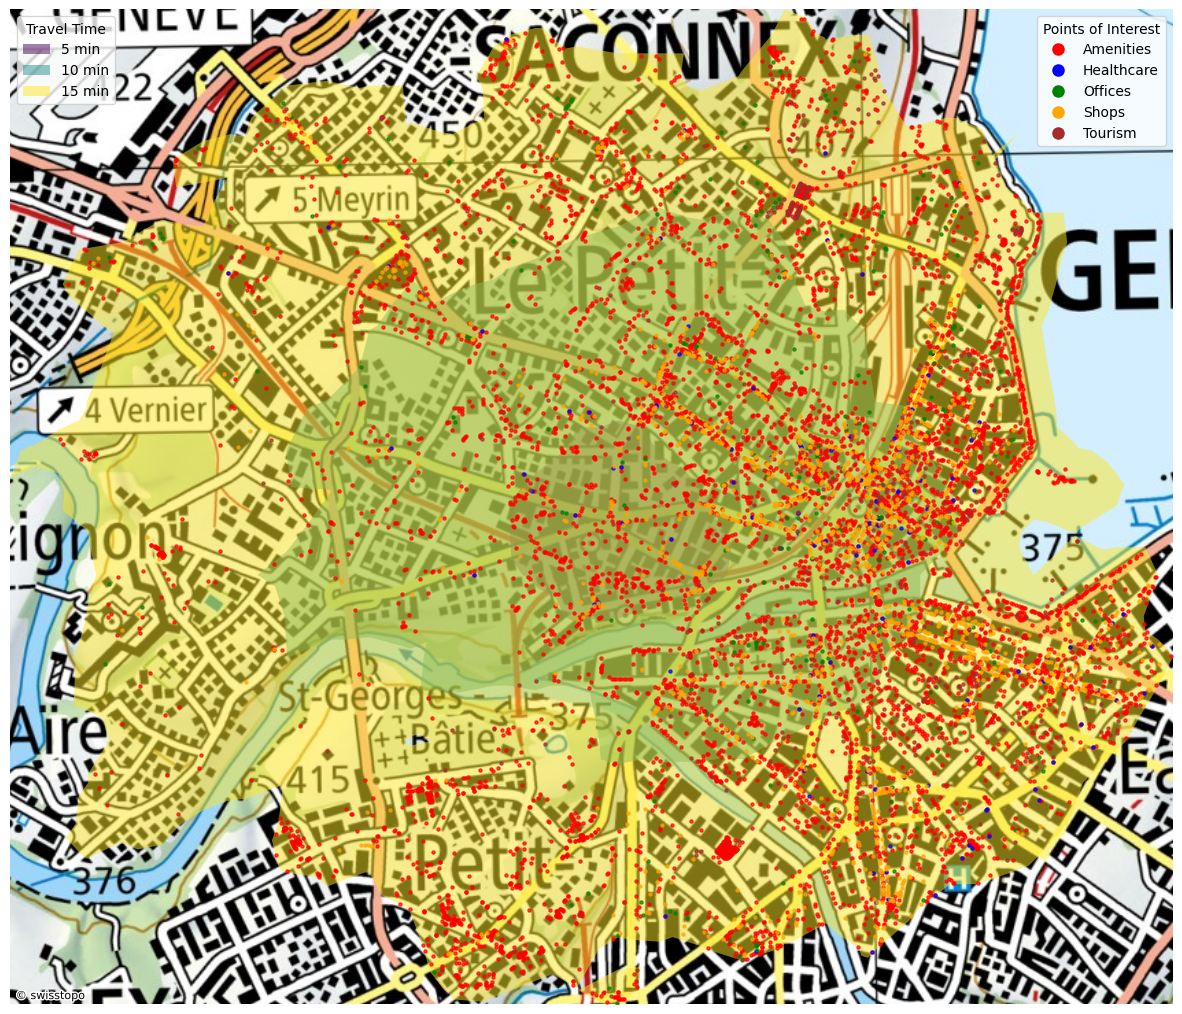

In [12]:
fig, ax = plot_with_basemap(output, pois=intersected_pois, zoom=14)
plt.show()

In [13]:
# save the intersected_pois to a csv file
intersected_pois.to_csv("intersected_pois.csv", index=False)

In [14]:
intersected_pois.groupby(["variable", "value"]).size().reset_index(
    name="counts"
).sort_values("counts", ascending=False).to_csv("intersected_pois_grouped.csv")